In [1]:
import memilio.simulation.secir as secir
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from datetime import datetime, date
import time
import seaborn as sns
plt.style.use("seaborn")

import scipy.stats

In [2]:
from utils_SA import simulate_model, generate_output_daywise

In [3]:
# openturns libraries

from __future__ import print_function
import openturns as ot
import openturns.viewer as viewer
ot.Log.Show(ot.Log.NONE)

import pickle

In [4]:
# Define Comartment names
compartments = ['Susceptible', 'Exposed', 'Carrier', 'Infected', 'Hospitalized', 'ICU', 'Recovered', 'Dead']
# Define age Groups
groups = ['0-4', '5-14', '15-34', '35-59', '60-79', '80+']

In [5]:
with open('Studies/study_dead_sobol_100000.pkl', 'rb') as f:
    size = pickle.load(f)
    input_factor_names = pickle.load(f)
    distributions = pickle.load(f) # saved as coll (collection of distributions)
    static_params = pickle.load(f)
    inputDesign = pickle.load(f)
    sim_out = pickle.load(f)
    runtime = pickle.load(f)

In [191]:
print(f"Size of Monte Carlo experiment is {size}.")
print(f"The Monte Carlo experiment needed {runtime} s.")
print(f"{len(input_factor_names)} input factors were used.")
print(f"The model was simulated {len(sim_out)} times.")
print(static_params)
#print(f"Considered input factors are {input_factor_names}")

Size of Monte Carlo experiment is 100000.
The Monte Carlo experiment needed 13.142532348632812 s.
74 input factors were used.
The model was simulated 7600000 times.
{'num_groups': 6, 'num_compartments': 8, 'populations': [40000, 70000, 190000, 290000, 180000, 60000], 'start_day': 0, 'days': 100, 'dt': 0.1, 'output_index': [7], 'output_operation': 'all'}


In [7]:
aggregation_function = "max"

if aggregation_function == "max":
    output_agg = np.max(sim_out, axis = 1, keepdims = True)
elif aggregation_function == "sum":
    output_agg = np.sum(sim_out, axis = 1, keepdims=True)
elif aggregation_function == "mean":
    output_agg = np.mean(sim_out, axis = 1, keepdims=True)

In [8]:
outputArray = np.array(sim_out)
outputArray.shape

(7600000, 101)

In [123]:
inputDesign[0]

74

# Display distribution of samples

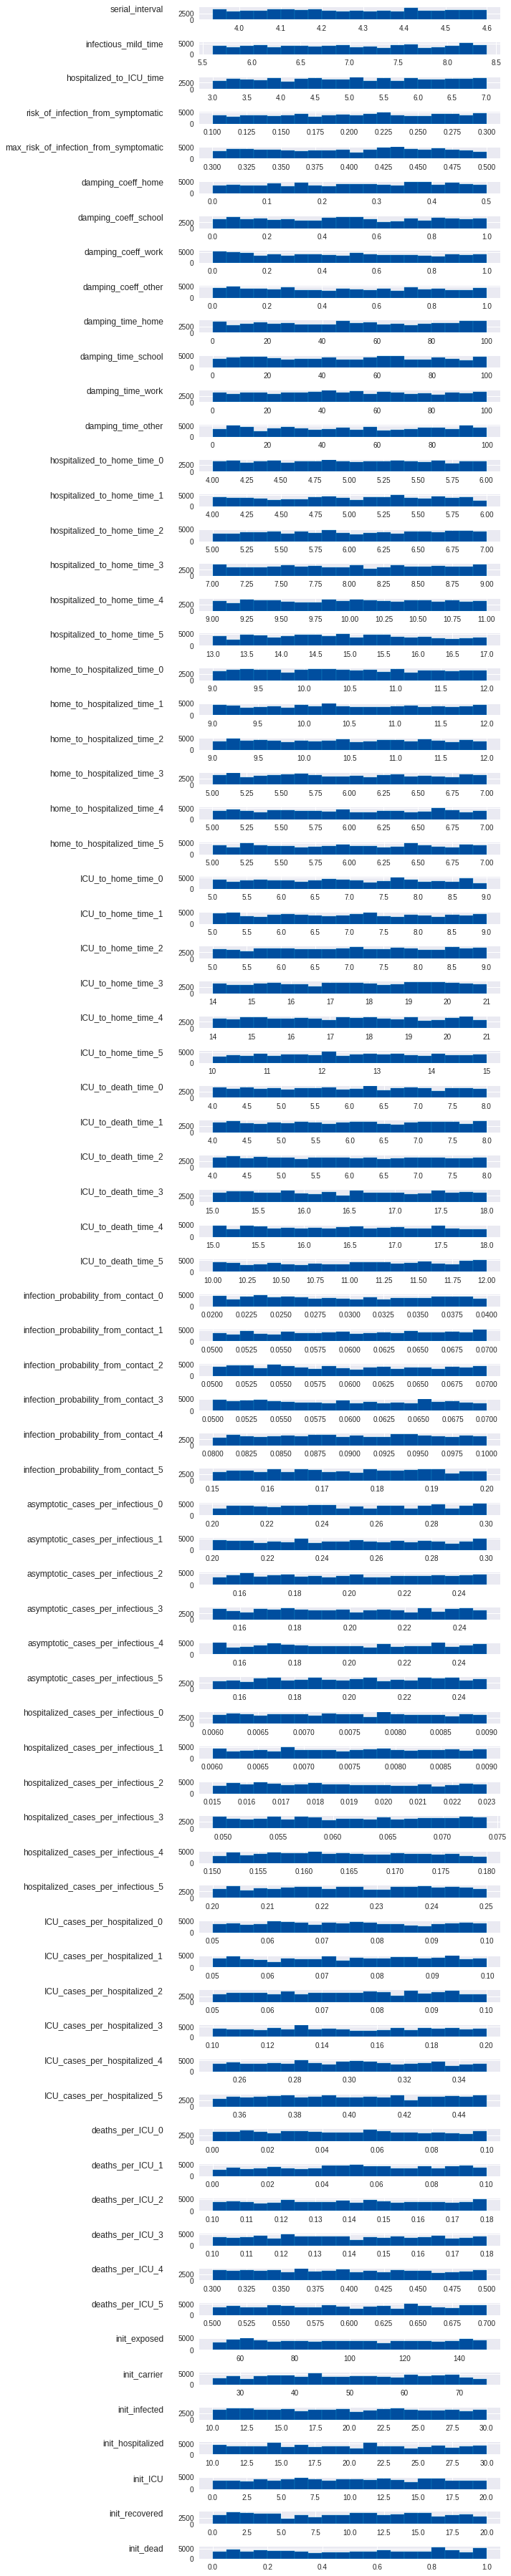

In [64]:
n = len(distributions)
n_bins = 20
fig, axes = plt.subplots(n, 1, figsize=(10, 50))
inputArray = np.array(inputDesign)

for i in range(n):
    axes[i].hist(inputArray[:, i], bins = n_bins, facecolor = '#004e9f', edgecolor = '#169acf')
    axes[i].set_ylabel(input_factor_names[i], rotation = 0, fontsize = 12, labelpad = 20, ha = 'right')
plt.tight_layout()
plt.show()

In [66]:
out_end = outputArray[:, -1]
out_end.shape

(76000,)

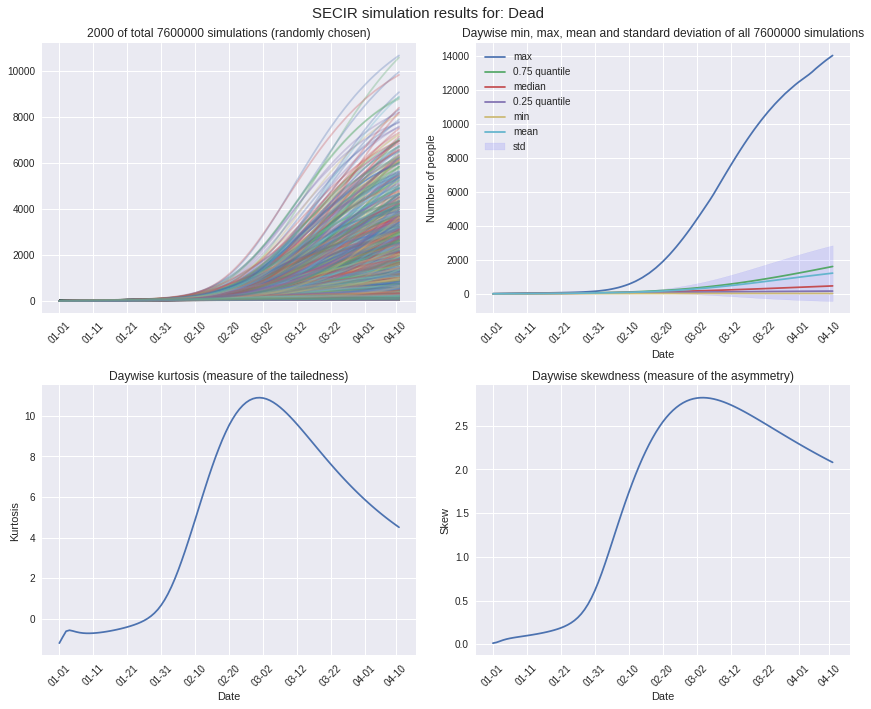

In [9]:
n_outputs = 2000
conf = 0.95

randidx = np.sort(np.random.randint(0, outputArray.shape[0], n_outputs))
#print(randidx)

title = f"SECIR simulation results for: {compartments[static_params['output_index'][0]]}"

fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 10), tight_layout = True)
fig.suptitle(title, fontsize = 15)

num_time_points = static_params['days'] + 1

data = outputArray[randidx, :]
x = np.arange(num_time_points)

days = static_params['days']
start_day = 1
start_month = 1
start_year = 2019

# Plot Results
datelist = np.array(
    pd.date_range(
        datetime(start_year, start_month, start_day),
        periods=days, freq='D').strftime('%m-%d').tolist())

tick_range = (np.arange(int(days / 10) + 1) * 10)
tick_range[-1] -= 1


for i in range(n_outputs):
    axs[0, 0].plot(x, data[i, :], alpha=0.3 )

axs[0, 0].set_title(f"{n_outputs} of total {len(outputArray)} simulations (randomly chosen)")

mean_result = np.array([np.mean(outputArray[:, i]) for i in range(num_time_points)])
#n = len(data)
#ci_result = np.array([scipy.stats.sem(data[:, i]) * scipy.stats.t.ppf((1+conf)/2., n-1) for i in range(num_time_points)])
std_result = np.array([np.std(outputArray[:, i]) for i in range(num_time_points)])

median_result = np.array([np.quantile(outputArray[:, i], q = 0.5) for i in range(num_time_points)])
low_quantile_result = np.array([np.quantile(outputArray[:, i], q = 0.25) for i in range(num_time_points)])
high_quantile_result = np.array([np.quantile(outputArray[:, i], q = 0.75) for i in range(num_time_points)])

kurtosis_result = np.array([scipy.stats.kurtosis(outputArray[:, i]) for i in range(num_time_points)])
skew_result = np.array([scipy.stats.skew(outputArray[:, i]) for i in range(num_time_points)])

min_result = np.array([np.min(outputArray[:, i]) for i in range(num_time_points)])
max_result = np.array([np.max(outputArray[:, i]) for i in range(num_time_points)])                      

axs[0, 1].plot(x, max_result, label = 'max')
axs[0, 1].plot(x, high_quantile_result, label = '0.75 quantile')
axs[0, 1].plot(x, median_result, label = 'median')
axs[0, 1].plot(x, low_quantile_result, label = '0.25 quantile')
axs[0, 1].plot(x, min_result, label = "min")
axs[0, 1].plot(x, mean_result, label = 'mean')
axs[0, 1].fill_between(x, 
                    (mean_result - std_result), (mean_result + std_result), 
                    color = 'b', alpha = .1, label = "std")

#axs[1].fill_between(x, (mean_result - ci_result), (mean_result + ci_result), color = 'b', alpha = .1)
#axs[1].set_title(f"Daywise mean with {conf} confidence interval.")
axs[0, 1].set_title(f"Daywise min, max, mean and standard deviation of all {len(outputArray)} simulations")
axs[0, 1].legend()

axs[1, 0].plot(x, kurtosis_result, label = 'kurtosis')
axs[1, 0].set_title(f"Daywise kurtosis (measure of the tailedness)")
axs[1, 1].plot(x, skew_result, label = 'skew')
axs[1, 1].set_title(f"Daywise skewdness (measure of the asymmetry)")

for j in range(2):
    for k in range(2):
        axs[j, k].set_xticks(tick_range)
        axs[j, k].set_xticklabels(datelist[tick_range], rotation=45)
    axs[0, k].set(ylabel = "Number of people", xlabel = "Date")
axs[1, 0].set(ylabel = "Kurtosis", xlabel = "Date")
axs[1, 1].set(ylabel = "Skew", xlabel = "Date")

plt.show()

### Histogram of aggregated simulation output

In [10]:
print(aggregation_function, compartments[static_params['output_index'][0]])
print(output_agg.shape)

max Dead
(7600000, 1)


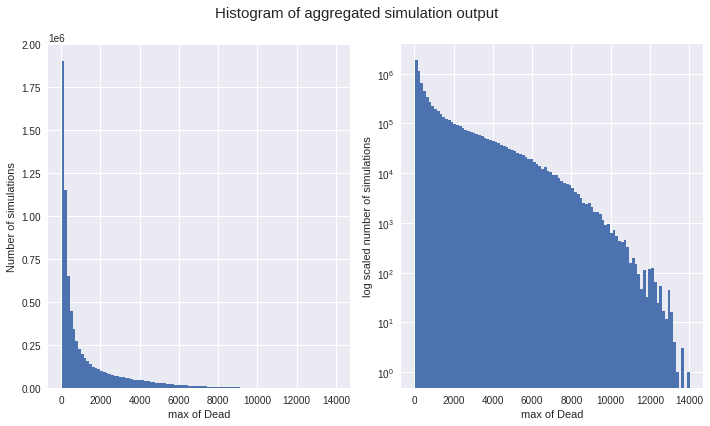

In [11]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 6), tight_layout = True)
fig.suptitle("Histogram of aggregated simulation output", fontsize = 15)
axs[0].hist(output_agg, bins = 100, density = False, log = False)
axs[0].set(xlabel = f"{aggregation_function} of {compartments[static_params['output_index'][0]]}", 
          ylabel = "Number of simulations")
axs[1].hist(output_agg, bins = 100, density = False, log = True)
axs[1].set(xlabel = f"{aggregation_function} of {compartments[static_params['output_index'][0]]}", 
          ylabel = "log scaled number of simulations")
plt.show()

Text(0.5, 1.0, 'Estimated density of max of simulation output: Dead')

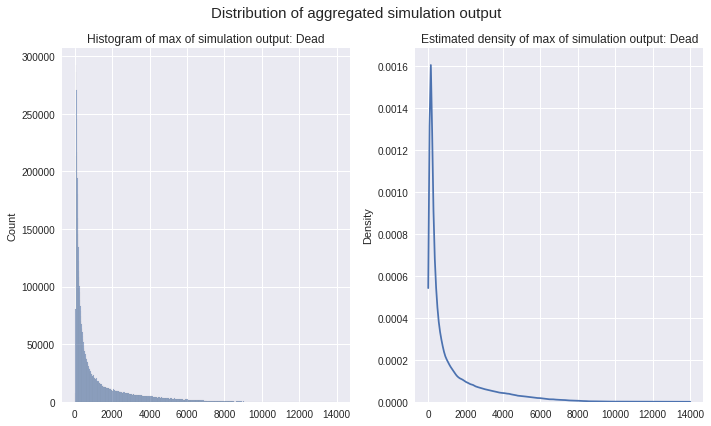

In [12]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 6), tight_layout = True)
fig.suptitle("Distribution of aggregated simulation output", fontsize = 15)
sns.histplot(ax = axs[0], data = output_agg, kde = False, legend = False)
sns.kdeplot(ax = axs[1], data = output_agg, legend = False, clip = [0, np.max(output_agg)])
axs[0].set_title(f"Histogram of {aggregation_function} of simulation output: {compartments[static_params['output_index'][0]]}")
axs[1].set_title(f"Estimated density of {aggregation_function} of simulation output: {compartments[static_params['output_index'][0]]}")

## Visual inspection

In [44]:
high_idx = [i for i, o in enumerate(output_agg[:,0]) if o > 11000]

len(output_agg[high_idx, 0])

1190

In [50]:
df = inputDesign[randidx].asDataFrame()
df["output_agg"] = output_agg[randidx, 0]
df.head()

serial_interval  infectious_mild_time  hospitalized_to_ICU_time  \
0         3.966953              7.612735                  3.090877   
1         4.295742              8.124175                  5.817704   
2         4.450385              6.136983                  6.622568   
3         4.506292              6.027340                  6.011075   
4         4.339831              5.816477                  6.350465   

   risk_of_infection_from_symptomatic  max_risk_of_infection_from_symptomatic  \
0                            0.136815                                0.345028   
1                            0.170029                                0.319235   
2                            0.157067                                0.498075   
3                            0.194946                                0.373031   
4                            0.144468                                0.341931   

   damping_coeff_home  damping_coeff_school  damping_coeff_work  \
0            0.279692              0.235131            0.491298   
1            0.477909              0.276862            0.201305   
2            0.095097              0.860198            0.520786   
3            0.397388              0.089555            0.394789   
4            0.008917              0.037404            0.329227   

   damping_coeff_other  damping_time_home  ...  deaths_per_ICU_4  \
0             0.357533          54.767664  ...          0.465372   
1             0.003706          67.737318  ...          0.323640   
2             0.077880          57.963053  ...          0.345256   
3             0.739177          14.297477  ...          0.453175   
4             0.697431          34.115982  ...          0.461024   

   deaths_per_ICU_5  init_exposed  init_carrier  init_infected  \
0          0.613527     58.628045     54.874918      18.147235   
1          0.500829    107.164215     67.494876      13.817480   
2          0.684466    108.109814     41.799694      14.997791   
3          0.555599    130.868720     38.002774      21.322743   
4          0.633165     66.568843     28.954079      14.480319   

   init_hospitalized   init_ICU  init_recovered  init_dead   output_agg  
0          21.033233   4.873676       13.745564   0.842023   745.154269  
1          19.507996   3.871624       11.827027   0.920710  2352.264692  
2          20.942701   6.998354        8.655436   0.532262   820.505443  
3          19.208657  18.726651        2.360005   0.278727   164.164556  
4          23.146516  12.707328        3.019341   0.255216   509.223065  

[5 rows x 75 columns]

In [47]:
import plotly.express as px
# https://plotly.com/python/parallel-coordinates-plot/
# https://plotly.com/python-api-reference/generated/plotly.graph_objects.Figure.html
# https://plotly.com/python/reference/parcoords/

In [57]:
fig = px.parallel_coordinates(df, color="output_agg",
                              dimensions = ['serial_interval', 'damping_coeff_school'],
                             color_continuous_scale = px.colors.diverging.Tealrose)
fig.show()

# Compute sensitivity indices

In [13]:
outputDesign = ot.Sample(output_agg)
sensitivityAnalysis = ot.JansenSensitivityAlgorithm(inputDesign, outputDesign, size)

agg_first_order = sensitivityAnalysis.getAggregatedFirstOrderIndices()
agg_total_order = sensitivityAnalysis.getAggregatedTotalOrderIndices()
print("Agg. first order indices: ", agg_first_order)
print("Agg. total order indices: ", agg_total_order)

first_order = sensitivityAnalysis.getFirstOrderIndices()
total_order = sensitivityAnalysis.getTotalOrderIndices()
print("First order indices: ", first_order)
print("Total order indices: ", total_order)

Agg. first order indices:  [0.18328,0.0285165,0.0187619,0.0712508,0.0084116,0.0175177,0.0297822,0.0333638,0.0289408,0.0165338,0.0439266,0.048276,0.0419626,0.00841159,0.00841134,0.00841668,0.00845985,0.00858629,0.00850085,0.00841147,0.00841169,0.00840748,0.00835986,0.00855617,0.00943803,0.00841149,0.00841239,0.00841011,0.00842943,0.00904705,0.00863311,0.00841184,0.00841128,0.00839844,0.00833391,0.00869042,0.00841603,0.00856398,0.00907376,0.0200792,0.020836,0.00993991,0.00930468,0.00840212,0.00844882,0.00839445,0.00836723,0.00848156,0.00835278,0.00841152,0.00841226,0.0084201,0.00844266,0.0082873,0.00892515,0.00841123,0.00841253,0.00842274,0.00890247,0.00898376,0.00910046,0.00840762,0.00841169,0.00843995,0.00823,0.00855991,0.0104313,0.0110632,0.00951721,0.00841235,0.00842604,0.00849409,0.00841254,0.00841411]#74
Agg. total order indices:  [0.342989,0.0470555,0.0240855,0.130911,0,0.0580261,0.0978473,0.0956069,0.0970329,0.135244,0.221875,0.216463,0.215834,4.09938e-10,8.90314e-10,2.66431e-07,

In [14]:
print(sensitivityAnalysis.getConfidenceLevel())

0.95


In [142]:
firstCI = sensitivityAnalysis.getFirstOrderIndicesInterval()
totalCI = sensitivityAnalysis.getTotalOrderIndicesInterval()
total = np.array(sensitivityAnalysis.getAggregatedTotalOrderIndices())
first = np.array(sensitivityAnalysis.getAggregatedFirstOrderIndices())

In [143]:
sorted_ids = list(map(int, np.argsort(total)))
print(sorted_ids)
type(sorted_ids[0])

[4, 19, 49, 13, 20, 14, 55, 50, 56, 25, 26, 31, 32, 72, 21, 61, 62, 15, 27, 51, 73, 43, 63, 57, 33, 70, 16, 34, 44, 71, 47, 28, 22, 69, 52, 48, 17, 18, 46, 64, 37, 58, 45, 36, 35, 29, 30, 53, 60, 38, 59, 23, 54, 41, 42, 24, 68, 66, 65, 67, 2, 39, 40, 1, 5, 7, 8, 6, 3, 9, 12, 11, 10, 0]


int

[4, 19, 49, 13, 20, 14, 55, 50, 56, 25, 26, 31, 32, 72, 21, 61, 62, 15, 27, 51, 73, 43, 63, 57, 33, 70, 16, 34, 44, 71, 47, 28, 22, 69, 52, 48, 17, 18, 46, 64, 37, 58, 45, 36, 35, 29, 30, 53, 60, 38, 59, 23, 54, 41, 42, 24, 68, 66, 65, 67, 2, 39, 40, 1, 5, 7, 8, 6, 3, 9, 12, 11, 10, 0]


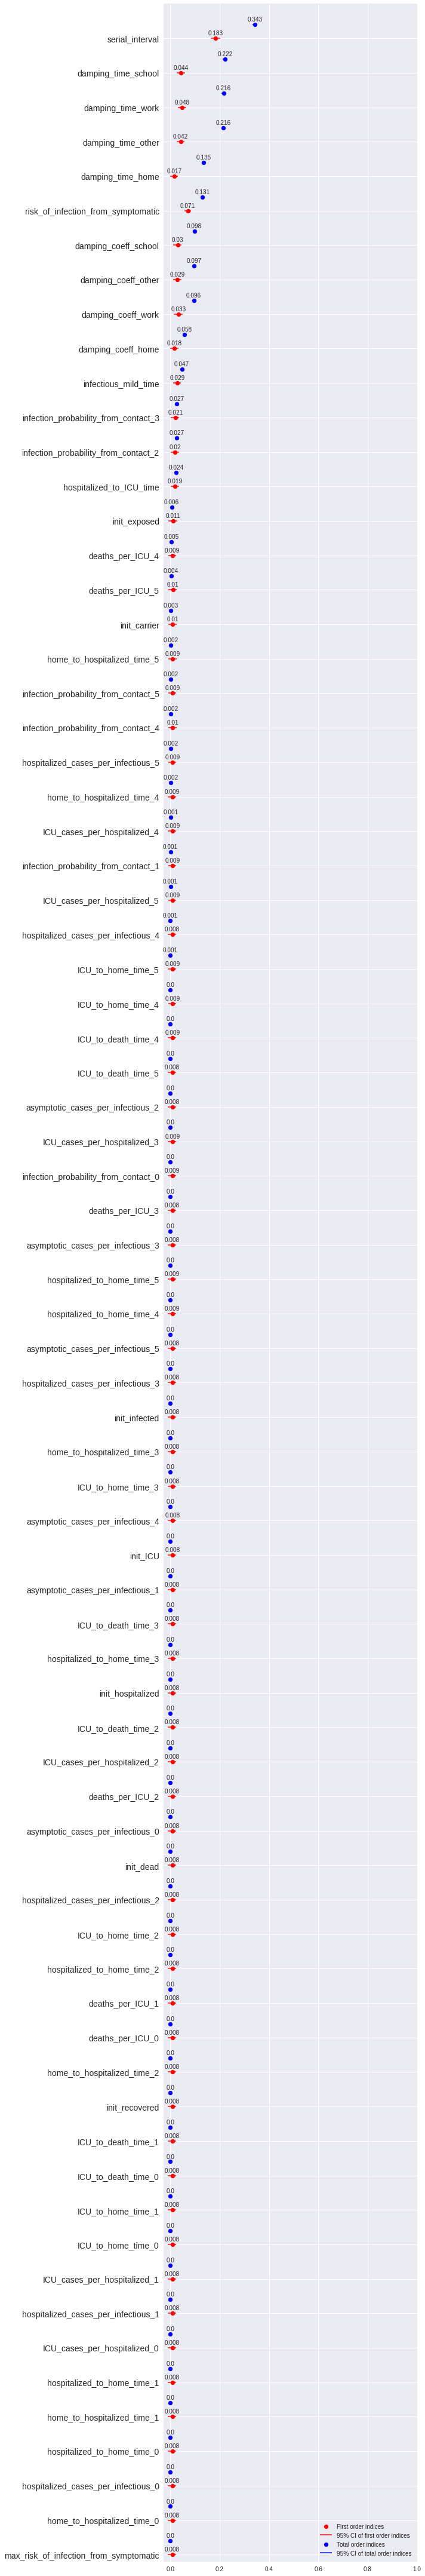

In [144]:
sorted_ids = list(map(int, np.argsort(total)))
print(sorted_ids)
n = len(distributions)
alp = 0.7
lw = 2
fig, axes = plt.subplots(1, 1, figsize=(10, 60))
inputArray = np.array(inputDesign)
x = np.arange(0, 1.1, 0.2)
y = np.arange(0, len(first), 1)
space = 0.4
y2 = np.arange(0+space, len(total)+space, 1)


axes.scatter(first[sorted_ids], y, label = "First order indices", c = 'red')
plt.hlines(y=0, xmin=0, xmax=0, 
               colors='red', linestyles='-', lw=lw, label = "95% CI of first order indices", alpha = alp)
axes.scatter(total[sorted_ids], y2, label = "Total order indices", c = 'blue')
plt.hlines(y=0, xmin=0, xmax=0, 
               colors='blue', linestyles='-', lw=lw, label = "95% CI of total order indices", alpha = alp)
for i, j in enumerate(sorted_ids):
    plt.hlines(y=y[i], xmin=firstCI.getMarginal(j).getLowerBound()[0], 
               xmax=firstCI.getMarginal(j).getUpperBound()[0], 
               colors='red', linestyles='-', lw=lw, alpha = alp)
    plt.hlines(y=y2[i], xmin=totalCI.getMarginal(j).getLowerBound()[0], 
               xmax=totalCI.getMarginal(j).getUpperBound()[0], 
               colors='blue', linestyles='-', lw=lw, alpha = alp)
    plt.annotate(str(np.round(first[sorted_ids[i]], 3)), (first[sorted_ids[i]], y[i]+ 0.25*space), ha='center')
    plt.annotate(str(np.round(total[sorted_ids[i]], 3)), (total[sorted_ids[i]], y2[i]+ 0.25*space), ha='center')
    

#axes.set_ylabel(input_factor_names[i], rotation = 0, fontsize = 12, labelpad = 20, ha = 'right')
axes.set_xticks(x)
axes.set_yticks(y)
axes.set_yticklabels([input_factor_names[k] for k in sorted_ids], fontsize = 14)
plt.legend(loc='lower right')
plt.ylim([-0.2, n])
#plt.xlim([-0.1, 1])
plt.tight_layout()
plt.show()

In [178]:
eps = 1e-2

# take only factors with total effect larger epsilon
relevant_ids = [i for i, t in enumerate(total) if t > eps]

print(relevant_ids)

# sort indices by main effect
sorted_ids = list(map(int, np.argsort(first)))
sorted_ids = np.array(sorted_ids)
print(sorted_ids)

# only take relevant
sorted_ids = [int(s) for i, s in enumerate(sorted_ids) if s in relevant_ids]
print(sorted_ids)
print(type(sorted_ids[0]))

[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 39, 40]
[64 53 34 48 22 46 45 33 43 21 61 27 55 32 14 19 25 49 13  4 20 62 31 50
 69 26 56 72 73 36 15 51 57 70 28 63 52 44 16 47 71 18 23 65 37 17 30 35
 58 54 59 29 38 60 42 24 68 41 66 67  9  5  2 39 40  1  8  6  7 12 10 11
  3  0]
[9, 5, 2, 39, 40, 1, 8, 6, 7, 12, 10, 11, 3, 0]
<class 'int'>


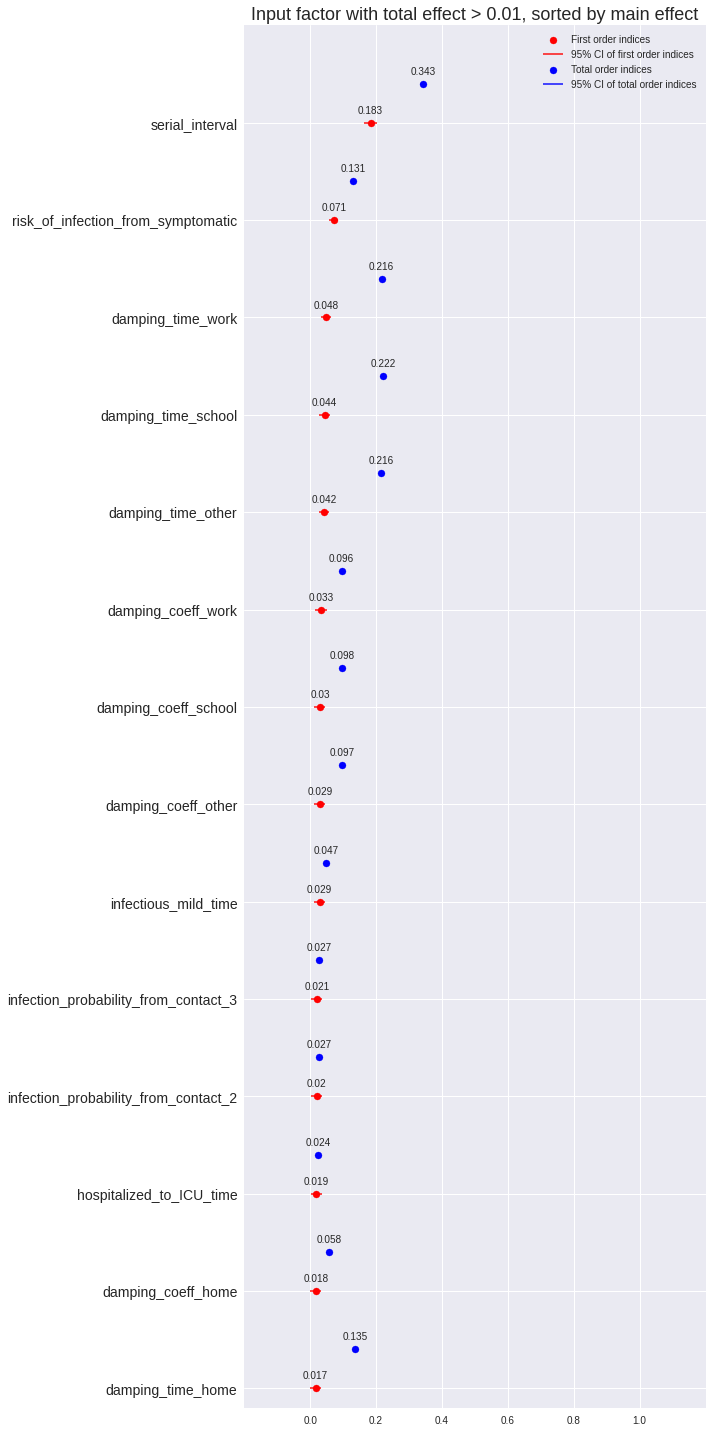

In [168]:
n = len(distributions)
alp = 0.7
lw = 2
fig, axes = plt.subplots(1, 1, figsize=(10, 20))
inputArray = np.array(inputDesign)
x = np.arange(0, 1.1, 0.2)
y = np.arange(0, len(sorted_ids), 1)
space = 0.4
y2 = np.arange(0+space, len(sorted_ids)+space, 1)


axes.scatter(first[sorted_ids], y, label = "First order indices", c = 'red')
plt.hlines(y=0, xmin=0, xmax=0, 
               colors='red', linestyles='-', lw=lw, label = "95% CI of first order indices", alpha = alp)
axes.scatter(total[sorted_ids], y2, label = "Total order indices", c = 'blue')
plt.hlines(y=0, xmin=0, xmax=0, 
               colors='blue', linestyles='-', lw=lw, label = "95% CI of total order indices", alpha = alp)
for i, j in enumerate(sorted_ids):
    plt.hlines(y=y[i], xmin=firstCI.getMarginal(j).getLowerBound()[0], 
               xmax=firstCI.getMarginal(j).getUpperBound()[0], 
               colors='red', linestyles='-', lw=lw, alpha = alp)
    plt.hlines(y=y2[i], xmin=totalCI.getMarginal(j).getLowerBound()[0], 
               xmax=totalCI.getMarginal(j).getUpperBound()[0], 
               colors='blue', linestyles='-', lw=lw, alpha = alp)
    plt.annotate(str(np.round(first[sorted_ids[i]], 3)), (first[sorted_ids[i]], y[i]+ 0.25*space), ha='center')
    plt.annotate(str(np.round(total[sorted_ids[i]], 3)), (total[sorted_ids[i]], y2[i]+ 0.25*space), ha='center')
    

#axes.set_ylabel(input_factor_names[i], rotation = 0, fontsize = 12, labelpad = 20, ha = 'right')
axes.set_xticks(x)
axes.set_yticks(y)
axes.set_yticklabels([input_factor_names[k] for k in sorted_ids], fontsize = 14)
plt.legend(loc='upper right')
plt.ylim([-0.2, len(sorted_ids)])
plt.xlim([-0.2, 1.2])
plt.title(f"Input factor with total effect > {eps}, sorted by main effect", fontsize = 18)
plt.tight_layout()
plt.show()

## Visualize most sensitive indices

In [204]:
# take only factors with total effect larger epsilon
eps = 1e-2
relevant_ids = [i for i, t in enumerate(total) if t > eps]

# sort indices by main effect
sorted_ids = list(map(int, np.argsort(first)))
sorted_ids = np.array(sorted_ids)

# only take relevant
relevant_sorted_ids = [int(s) for i, s in enumerate(sorted_ids) if s in relevant_ids]

relevant_idx = list(reversed(relevant_sorted_ids)) #[i for i, o in enumerate(total) if o > eps]
print(relevant_sorted_ids)
print(relevant_idx)
relevant_columns = [list(df.columns)[i] for i in relevant_idx]
relevant_columns

[9, 5, 2, 39, 40, 1, 8, 6, 7, 12, 10, 11, 3, 0]
[0, 3, 11, 10, 12, 7, 6, 8, 1, 40, 39, 2, 5, 9]


['serial_interval',
 'risk_of_infection_from_symptomatic',
 'damping_time_work',
 'damping_time_school',
 'damping_time_other',
 'damping_coeff_work',
 'damping_coeff_school',
 'damping_coeff_other',
 'infectious_mild_time',
 'infection_probability_from_contact_3',
 'infection_probability_from_contact_2',
 'hospitalized_to_ICU_time',
 'damping_coeff_home',
 'damping_time_home']

In [69]:
import plotly.graph_objects as go

In [198]:
df['output_agg'].max()

10664.62017320715

In [117]:
color_categories = [[0, 'purple'], [0.25, 'lightseagreen'], [0.75, 'gold'], [1., 'white']]

In [205]:
print(relevant_idx)
dims = []
for i,  rx in enumerate(relevant_idx):
    dims.append(dict(range = [distributions[rx].getRange().getLowerBound()[0], distributions[rx].getRange().getUpperBound()[0]], 
                    label = relevant_columns[i],
                    values = df[relevant_columns[i]]))

#dims[2].update(constraintrange = [6, 7.0])
dims[0].update(constraintrange = [3.935, 4.2])

dims.append(dict(
    range = [0, df['output_agg'].max()], constraintrange = [10000, 14000],
    label = "output", values = df['output_agg']))

[0, 3, 11, 10, 12, 7, 6, 8, 1, 40, 39, 2, 5, 9]


In [206]:
fig = go.Figure(data =
                   go.Parcoords(
                   line = dict(color = df['output_agg'],
                              colorscale = color_categories, #continous: 'Electric', 
                              showscale = True, 
                              cmin = 0,
                              cmax = df['output_agg'].max(),
                              ),
                   dimensions = dims,
                   labelangle = 45,
                   ),
               layout = go.Layout(margin = go.layout.Margin(t = 150))
               )
fig.show()

In [195]:
# take only factors with total effect larger epsilon
eps = 1e-8
relevant_ids = [i for i, t in enumerate(total) if t <= eps]

# sort indices by total effect
sorted_ids = list(map(int, np.argsort(total)))
sorted_ids = np.array(sorted_ids)

# only take relevant
relevant_sorted_ids = [int(s) for i, s in enumerate(sorted_ids) if s in relevant_ids]

relevant_idx = list(reversed(relevant_sorted_ids)) #[i for i, o in enumerate(total) if o > eps]
print(relevant_sorted_ids)
print(relevant_idx)
print(len(relevant_idx))
relevant_columns = [list(df.columns)[i] for i in relevant_idx]
relevant_columns

[4, 19, 49, 13, 20, 14, 55, 50, 56, 25]
[25, 56, 50, 55, 14, 20, 13, 49, 19, 4]
10


['ICU_to_home_time_0',
 'ICU_cases_per_hospitalized_1',
 'hospitalized_cases_per_infectious_1',
 'ICU_cases_per_hospitalized_0',
 'hospitalized_to_home_time_1',
 'home_to_hospitalized_time_1',
 'hospitalized_to_home_time_0',
 'hospitalized_cases_per_infectious_0',
 'home_to_hospitalized_time_0',
 'max_risk_of_infection_from_symptomatic']

In [201]:
dims = []
for i,  rx in enumerate(relevant_idx):
    dims.append(dict(range = [distributions[rx].getRange().getLowerBound()[0], distributions[rx].getRange().getUpperBound()[0]], 
                    label = relevant_columns[i],
                    values = df[relevant_columns[i]]))

dims.append(dict(
    range = [0, df['output_agg'].max()], constraintrange = [10000, 14000],
    label = "output", values = df['output_agg']))

fig = go.Figure(data =
                   go.Parcoords(
                   line = dict(color = df['output_agg'],
                              colorscale = color_categories, #continous: 'Electric', 
                              showscale = True, 
                              cmin = 0,
                              cmax = df['output_agg'].max(),
                              ),
                   dimensions = dims,
                   labelangle = 45,
                   ),
               layout = go.Layout(margin = go.layout.Margin(t = 150))
               )
fig.show()

# Second order Sensitivity Analysis

In [62]:
with open('Studies/study_dead_sobol_second_order.pkl', 'rb') as f:
    size = pickle.load(f)
    input_factor_names = pickle.load(f)
    distributions = pickle.load(f) # saved as coll (collection of distributions)
    static_params = pickle.load(f)
    inputDesign = pickle.load(f)
    sim_out = pickle.load(f)

In [63]:
aggregation_function = "max"

if aggregation_function == "max":
    output_agg = np.max(sim_out, axis = 1, keepdims = True)
elif aggregation_function == "sum":
    output_agg = np.sum(sim_out, axis = 1, keepdims=True)
elif aggregation_function == "mean":
    output_agg = np.mean(sim_out, axis = 1, keepdims=True)
    
outputDesign = ot.Sample(output_agg)
sensitivityAnalysis = ot.JansenSensitivityAlgorithm(inputDesign, outputDesign, size)

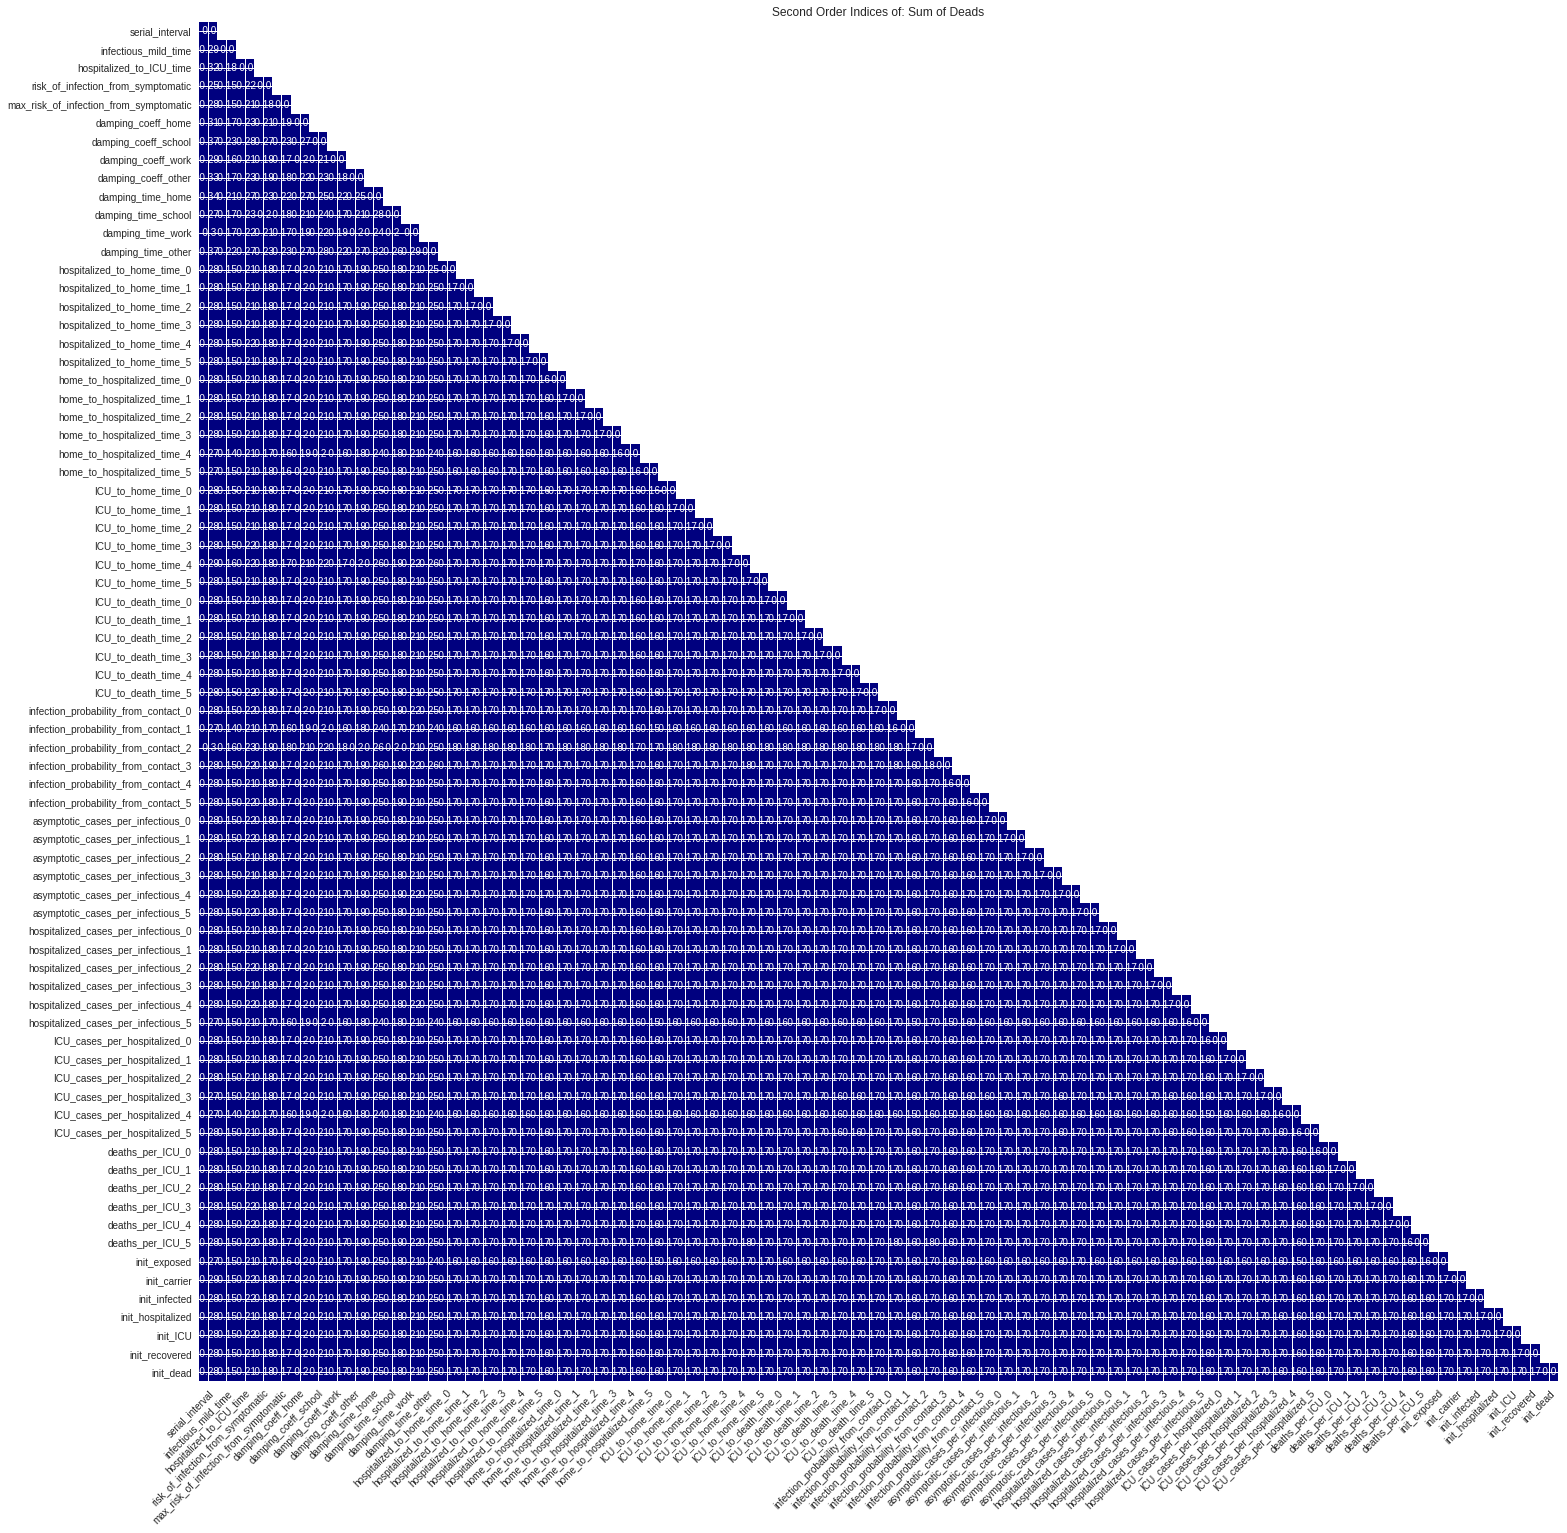

In [64]:
second_order = sensitivityAnalysis.getSecondOrderIndices()*(-1)
mask = np.ones_like(second_order)
mask[np.tril_indices_from(mask)] = False

f, ax = plt.subplots(figsize = (25,25))

masked_secondorder = np.ma.array(second_order, mask = mask)

cmap = cm.get_cmap('jet', 25)
cmap.set_bad('w')

im = ax.imshow(masked_secondorder, 
                #mask = mask, linewidth = 1, annot = True, 
                       #xticklabels = input_factor_names, yticklabels = input_factor_names, 
                vmin = 0, vmax = 1, cmap = cmap)


ax.set_xticks(np.arange(len(input_factor_names)))
ax.set_yticks(np.arange(len(input_factor_names)))

ax.set_xticklabels(input_factor_names)
ax.set_yticklabels(input_factor_names)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")


for i in range(len(input_factor_names)):
    for j in range(len(input_factor_names)):
        text = ax.text(j, i, np.round(second_order[i, j], 2),
                       ha="center", va="center", color="w")

ax.set_title("Second Order Indices of: Sum of Deads")


plt.show()

In [65]:
eps = 1e-2
(np.array(second_order).sum(axis =1) > eps).sum()
second_order = np.array(second_order)
relevant_ids = np.array(second_order).sum(axis =1) > eps

In [66]:
relevant_names = np.array(input_factor_names)[relevant_ids]
len(relevant_names)

0

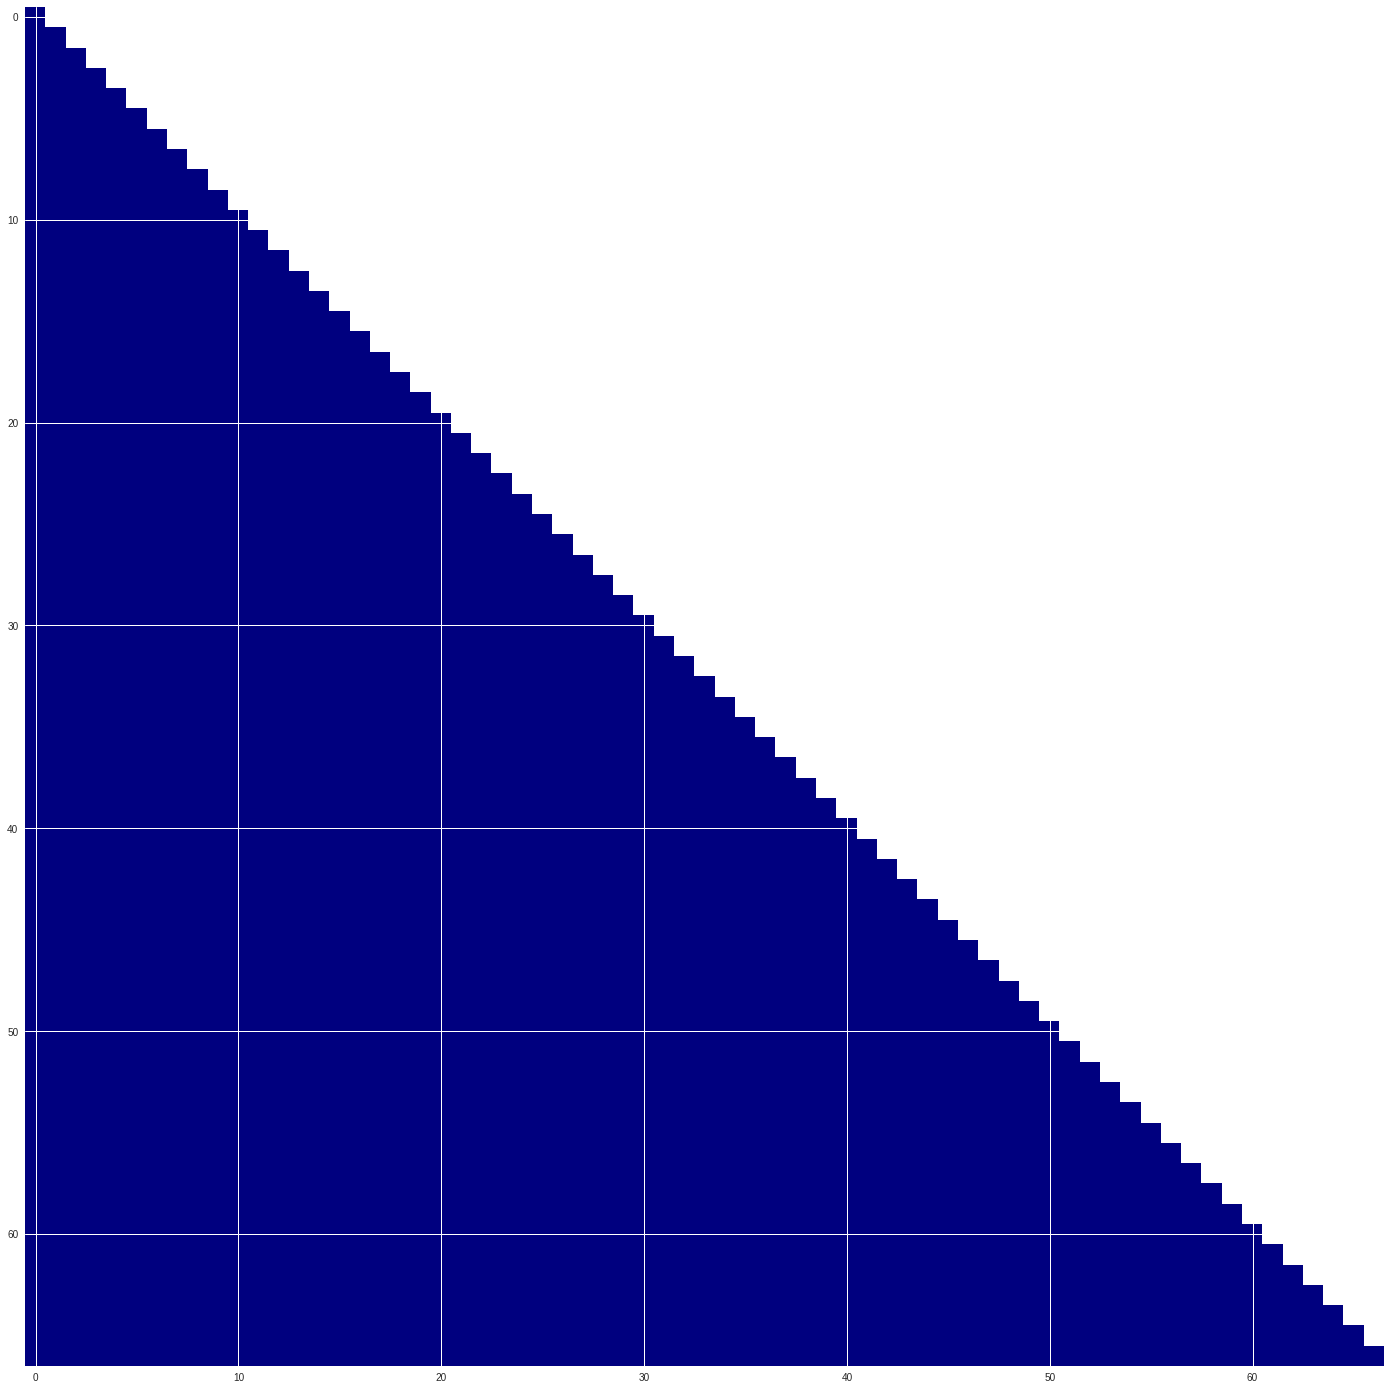

In [119]:
reduced_matrix = second_order[relevant_ids, :][:, relevant_ids]

mask = np.ones_like(reduced_matrix)
mask[np.tril_indices_from(mask)] = False

f, ax = plt.subplots(figsize = (25,25))

masked_secondorder = np.ma.array(reduced_matrix, mask = mask)

cmap = cm.get_cmap('jet', 25)
cmap.set_bad('w')

im = ax.imshow(masked_secondorder, 
                #mask = mask, linewidth = 1, annot = True, 
                       #xticklabels = input_factor_names, yticklabels = input_factor_names, 
                vmin = 0, vmax = 1, cmap = cmap)

ax.set_xticks(np.arange(len(relevant_names)))
ax.set_yticks(np.arange(len(relevant_names)))

ax.set_xticklabels(relevant_names)
ax.set_yticklabels(relevant_names)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")


for i in range(len(relevant_names)):
    for j in range(len(relevant_names)):
        text = ax.text(relevant_names[j], relevant_names[i], np.round(reduced_matrix[i, j], 2),
                       ha="center", va="center", color="w")

ax.set_title("Second Order Indices of: Sum of Deads")



plt.show()